# Priorisation de mails : Notebook 1

Ce notebook a pour objectif de construire un modèle de classification de mails d'une boite mails générique
Il prend en entrée la base de donnée de mails ainsi que les critères des exploitants sous format excel et génère en sortie un modèle entrainé 

## Importer les librairies nécessaires

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:

#Analyse des données
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Traitement de données texte
import nltk
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

#Classification
import sklearn
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import joblib

## Definir les variables spécifique à la base de données

In [3]:
import os
os.getcwd()

'C:\\Users\\massermouh'

In [4]:
# définir les fichiers d'entrée et les critères

fichier_mails = '.\Documents\Priorisation de mails\database_annotation.xlsx'
fichier_critères = '.\Documents\Priorisation de mails\critères exploitants.xlsx'

xl_mails = pd.ExcelFile(fichier_mails, engine='openpyxl', )
df_mails = xl_mails.parse('Sheet1')

xl_critères = pd.ExcelFile(fichier_critères, engine='openpyxl', )
df_critères = xl_critères.parse('Feuil1')

#top senders : les scores vont varier de 0 à 3
top_senders = df_critères['noms expéditeurs importants']
top_senders.dropna(inplace=True)
top_senders = top_senders.to_list()


#mots clés métier : les scores vont varier de 0 à 4
wording_metier = df_critères['mots métier importants']
wording_metier.dropna(inplace=True)
wording_metier = wording_metier.to_list()


#mots clés d'importance/urgence : les scores vont varier de 0 à 4
wording_importance = ["important","urgent","risque","erreur"]

In [5]:
# df_mails = df_mails.drop('0',axis=1)
df_mails.head(2)

,Unnamed: 0,Subject,Date_Sent,Body,From (address),To (address)
0,9604,Re: PANNEAUX 321 en attente de servitude,2021-01-04 07:13:07,Bonjour Emmanuel et meilleurs voeux à tous pou...,franck.glarey@airbus.com,n16aeroparc
1,9603,RE: PANNEAUX 321 en attente de servitude,2021-01-04 07:26:56,"Bonjour Franck, Le nécessaire sera fait afin d...",n16aeroparc@groupe-idea.com,"GLAREY, FRANCK; n16aeroparc"


In [6]:
#extraire la base de données contenant que les mails reçus si besoin

s ='n16aeroparc'
mails_reçus = df_mails[df_mails['From (address)'].str.contains(s)==False]

############ à compléter rec_df ##############

In [7]:
len(mails_reçus)

6650

## Annotation de la base de données

In [8]:
# Initier le dataframe qui va contenir ces critères

scores = pd.DataFrame(columns=['top_senders', 'wording_metier', 'wording_importance','destinataires','majuscule','exclamation'])

In [9]:
# Remplir le dataframe des critères

for idx, row in mails_reçus.iterrows():
    
    score_senders = 0
    w_metier = 0
    w_importance = 0
    destinataires = 0
    maj = 0
    exc = 0
    l = []
    
    
    #score top_senders
    for x in top_senders :
        #if row['From (address)'].__contains__(x):
        if x in str(row['From (address)']).lower():
            score_senders = score_senders + 1
    l.append(score_senders)
    
    #score wording metier
    for v in wording_metier :
        if v in str(row['Subject']).lower():
        #if row['Subject'].str.lower().str.contains(v):
            w_metier = w_metier + 1
        if v in str(row['Body']).lower():
            w_metier = w_metier + 1
    l.append(w_metier)
    
    #score wording_importance
    for w in wording_importance :
        if w in str(row['Subject']).lower():
            w_importance = w_importance + 1
        if w in str(row['Body']).lower():
            w_importance = w_importance + 1
    l.append(w_importance)
    
    #score nombre de destinataires
    z = str(row['To (address)']).lower()
    #z = replace_substring(z, s, '@IDEA')
    if len(z)==0:
        destinataires = 0
    else :
        destinataires = z.count(';') + 1
    l.append(destinataires)
    
    #score mots majuscule
    maj = sum(map(str.isupper, str(row['Body']).split())) + sum(map(str.isupper, str(row['Subject']).split()))
    l.append(maj)
    
    #score nombre de points d'exclamation
    a = str(row['Body']).lower()
    b = str(row['Subject']).lower()
    exc = a.count('!') + b.count('!')
    l.append(exc)
    
    #ajout de la ligne qui correspont a ce row au dataframe 
    #print(len(scores))

    scores.loc[len(scores)] = l

#normalisation des scores 

scores['top_senders'] = scores['top_senders']/max(scores['top_senders'])
scores['wording_metier'] = scores['wording_metier']/max(scores['wording_metier'])
scores['wording_importance'] = scores['wording_importance']/max(scores['wording_importance'])
scores['destinataires'] = scores['destinataires']/max(scores['destinataires'])
scores['majuscule'] = scores['majuscule']/max(scores['majuscule'])
scores['exclamation'] = scores['exclamation']/max(scores['exclamation'])

# Calcul du score moyen pour chaque mail

col = scores.loc[: , "top_senders":"exclamation"]
scores['score_moyen'] = col.mean(axis=1)

scores.fillna(0, inplace=True)

(array([4.655e+03, 1.411e+03, 2.730e+02, 1.360e+02, 1.030e+02, 4.100e+01,
        1.900e+01, 9.000e+00, 2.000e+00, 1.000e+00]),
 array([0.0021645 , 0.05434304, 0.10652157, 0.15870011, 0.21087865,
        0.26305718, 0.31523572, 0.36741425, 0.41959279, 0.47177133,
        0.52394986]),
 <BarContainer object of 10 artists>)

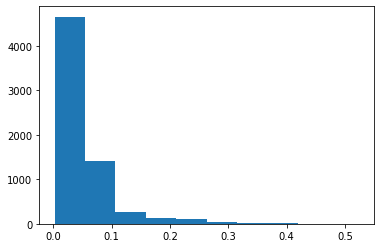

In [10]:
# Visualiser la destribution des scores moyens

plt.hist(list(scores['score_moyen']))


In [13]:
set(arr[:,-1])

{0.0, 1.0}

In [12]:
# méthode d'annotation 1 : on calcule le score moyen et on fait un tresholding 

tresh = 0.05434304

sc = scores.copy()
arr = sc.to_numpy()

#print(arr.shape)

for i in range(len(arr[:,-1])):
    if arr[i,-1]<tresh :
        arr[i,-1] = 0
    else:
        arr[i,-1] = 1

print("nombre de mails pas importants : ",np.count_nonzero(arr[:,-1]==0))
print("nombre de mails importants : ",np.count_nonzero(arr[:,-1]))


nombre de mails pas importants :  4655
nombre de mails importants :  1995


## Génération des attributs

In [14]:
mails_reçus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6650 entries, 0 to 9603
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Unnamed: 0      6650 non-null   int64         
 1   Subject         6641 non-null   object        
 2   Date_Sent       6650 non-null   datetime64[ns]
 3   Body            6584 non-null   object        
 4   From (address)  6650 non-null   object        
 5   To (address)    6643 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 363.7+ KB


In [15]:
mails_reçus.isna().sum()

Unnamed: 0         0
Subject            9
Date_Sent          0
Body              66
From (address)     0
To (address)       7
dtype: int64

In [16]:
mails_reçus['Body'] = mails_reçus['Body'].astype('string')
mails_reçus['Subject'] = mails_reçus['Subject'].astype('string')
mails_reçus['From (address)'] = mails_reçus['From (address)'].astype('string')
mails_reçus['To (address)'] = mails_reçus['To (address)'].astype('string')

In [17]:
mails_reçus.fillna('',inplace=True)

In [18]:
# Génération des attributs non textuels

crit = pd.DataFrame()

# Création d'autres attributs non textuels :

# 1 - longeur du mail

crit["longeur"] = mails_reçus['Body'].str.split().map(len)

# 2 - Nombre de destinataires/copies

nb_destinataires = []

for element in mails_reçus['To (address)'] :
    w = str(element).lower()
    if len(w)==0:
        dest = 0
    else :
        dest = w.count(';') + 1
        
    
    nb_destinataires.append(dest)
      

crit = crit.assign(nombre_de_destinataires = nb_destinataires)

# 3 - nombre de mots en majuscule

mots_maj = []

for idx, row in mails_reçus.iterrows():
    maj = sum(map(str.isupper, str(row['Body']).split())) + sum(map(str.isupper, str(row['Subject']).split()))
    mots_maj.append(maj)

crit = crit.assign(mots_maj = mots_maj)

#4 - nombre de lettres majuscules

lettres_maj = []

for idx, row in mails_reçus.iterrows():
    maj = sum(i.isupper() for i in str(row['Body']))
    lettres_maj.append(maj)

crit = crit.assign(lettres_maj = lettres_maj)

# 5 -  nombre de ponctuations
punct_counts = []

import string 
    
punct = string.punctuation

for idx, row in mails_reçus.iterrows():
    punct_count = 0
    for element in punct :
        punct_count = punct_count + str(row['Body']).count(element)
    punct_counts.append(punct_count)
    
crit = crit.assign(punct_counts = punct_counts)


# # 6 -  nombre de points d'exclamation

# pts_exclamation = []

# for idx, row in df_mails.iterrows():
#     a = str(row['Body']).lower()
#     b = str(row['Subject']).lower()
#     exc = a.count('!') + b.count('!')
#     pts_exclamation.append(exc)

# crit = crit.assign(pts_exclamation = pts_exclamation)

# # 7 -  longeur moyenne du mot

# from statistics import mean

longueur_moy_mots = []

for idx, row in mails_reçus.iterrows():
    ls = [len(x) for x in str(row['Body']).split()]
    longueur_moy_mots.append(np.mean(ls))

crit = crit.assign(longueur_moy_mots = longueur_moy_mots)

# 8 -  longeur moyenne de phrase
# import re

# longeur_moy_phrase = []

# for idx, row in rec_df.iterrows():
    
#     new_body = str(row['Body']).replace('!', '.').replace('?', '.')
#     split_list = new_body.split('.')
#     k = [len(x.split()) for x in split_list]
#     longeur_moy_phrase.append(np.mean(k))

# crit = crit.assign(longeur_moy_phrase = longeur_moy_phrase)



# # 9 -  ratio stop words

ratios = []

for idx, row in mails_reçus.iterrows():
    
    if len(str(row['Body']).split()) != 0:
        
        x = sum([str(row['Body']).split().count(x) for x in (set(stopwords.words('french')) | set(stopwords.words('english')))])/len(str(row['Body']).split())
    
        rat = x/len(str(row['Body']).split())
        ratios.append(rat)
    else :
        ratios.append(0)

crit = crit.assign(ratios = ratios)

# # 10 - nombre de mots uniques

uniques = []
for idx, row in mails_reçus.iterrows():
    uniques.append(len(set(str(row['Body']).split())))

crit = crit.assign(uniques = uniques)

# 11 -  nombre de digits

nb_digits = []
digits = list(range(10))

for idx, row in mails_reçus.iterrows():
    d = 0
    for e in digits :
        d = d + str(row['Body']).count(str(d))
    nb_digits.append(d)
    
crit = crit.assign(nb_digits = nb_digits)    

# 12 - nombre de mots contenants digits et lettres

import string

nb_ref = []

for idx, row in mails_reçus.iterrows():
    x = 0
    for element in str(row['Body']).split() :
        if len(set(list(element))&set(list(string.ascii_lowercase)))*len(set(list(range(10)))&set(list(element))) !=0 :
            x = x + 1
    nb_ref.append(x)

crit = crit.assign(nb_ref = nb_ref)
            

In [19]:
crit.shape

(6650, 10)

In [20]:
# création d'un dataframe avec une colonne texte contenant le body le sujet et les expéditeurs

matrice = pd.DataFrame()
matrice["text"] = mails_reçus['From (address)'].astype(str) + mails_reçus["Subject"].astype(str) + mails_reçus["Body"].astype(str)

In [21]:
### Génération des attributs textuels :

messages = matrice["text"]

## Preprocessing : 

#Preprocess text messages

# Replace URLs with 'webaddress'
processed = messages.str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
processed = processed.str.replace(r'£|\$', 'moneysymb')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
processed = processed.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'phonenumbr')
    
# Replace numbers with 'numbr'
processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr')

# Remove punctuation
processed = processed.str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
processed = processed.str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
processed = processed.str.replace(r'^\s+|\s+?$', '')

# change words to lower case 
processed = processed.str.lower()

# remove french stop words from text messages

stop_words = set(stopwords.words('french'))

processed = processed.apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

# remove english stop words from text messages

stop_words = set(stopwords.words('english'))
# stop_words.add('bonjour')
stop_words.add('please')
stop_words.add('mailto')
stop_words.add('mail')
stop_words.add('numbr')
# stop_words.add('cordialement')
stop_words.add('e')
stop_words.add('virus')
stop_words.add('antiphishing')
stop_words.add('merci')
stop_words.add('com')
stop_words.add('fr')
stop_words.add('https')
stop_words.add('bjenumbrywvybnumbrbhcmnaznumbrjvdxbllwlkzweuynumbrt')

processed = processed.apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

#Appliquer la tf-idf pour trouver les mots contenus dans les mails avec leurs scores d'importance

vect = TfidfVectorizer(max_df=0.50, min_df=2)
X = vect.fit_transform(processed)
len(vect.get_feature_names())



10396

In [49]:
#X = np.nan_to_num(X, posinf = 999999)

In [22]:
#Fonctions utiles

# finding the top keywords in the emails

def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)
def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# The find_features function will determine which of the 2000 word features are contained in the review

def find_features(message):
    words = word_tokenize(message)
    features = {}
    for word in feats:
        features[word] = (word in words)

    return features

#Prendre les 2000 mots les plus importants comme attribus textuels

features = vect.get_feature_names()
#print(top_mean_feats(X, features, top_n=10))
top_feats = top_mean_feats(X, features, top_n=2000)
feats = top_feats['features']
len(feats)

2000

In [23]:
#Créer la base de données des attributs combinés et la séparer en dataset de train et de test

featuresets = [find_features(text) for text in processed]
crit_text = pd.DataFrame.from_dict(featuresets)
crit_all = pd.concat([crit.reset_index(drop=True),crit_text.reset_index(drop=True)], axis=1)
crit_all = crit_all.replace([np.inf, -np.inf,np.nan], 0)
crit_all = crit_all.reset_index()
records = crit_all.to_dict('records')
y = arr[:,-1]
Z = [(records[i], y[i]) for i in range(0, len(records))]

all_indices = list(range(len(Z)))

train_indices, test_indices = model_selection.train_test_split(all_indices, test_size = 0.25, random_state = 42)

#print(train_indices)
training = [Z[i] for i in train_indices]
testing = [Z[i] for i in test_indices]

## Classification

In [24]:
#Classification avec l'algorithme random forest 

model = SklearnClassifier(RandomForestClassifier())

# train the model on the training data
model.train(training)

# and test on the testing dataset!
accuracy = nltk.classify.accuracy(model, testing)*100
print("Random Forest Accuracy: {}".format(accuracy))

Random Forest Accuracy: 90.55923030667469


## Saving the model

In [25]:
model_file = './Documents/Priorisation de mails/model_magasinX.joblib'
joblib.dump(model, model_file)

['./Documents/Priorisation de mails/model_magasinX.joblib']

## Saving the textual features

In [26]:
np.save("./Documents/Priorisation de mails/features_magasinX.npy", list(feats))